# Tutorial

We're going to look at some features of `redflag`, a library for helping find problems in machine learning pipelines.

You'll need the following packages to run the code in this tutorial:

- `redflag`
- `pandas`
- `seaborn`


## A simple ML workflow

First, let's see how we can burn ourselves:

In [1]:
X = [[19], [23], [35], [64], [59], [31]]  # The smallest gamma-ray log.
y = ['ss', 'ss', 'ss', 'ms', 'ms', 'ss']

from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X, y)
clf.predict(X)

array(['ss', 'ss', 'ss', 'ms', 'ms', 'ss'], dtype='<U2')

So far so good. We're predicting on the training data, but everything is at least working.

Now someone tells us we should scale our training data.

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

clf.fit(X_scaled, y)
clf.predict(X)  # <-- Oops, we predicted on unscaled data.

array(['ms', 'ms', 'ms', 'ms', 'ms', 'ms'], dtype='<U2')

Easily done. There are lots of people on Stack Overflow and Cross Validated wondering why all their predictions are the same. It's often because they've done something like this.

Even easier is this common pattern:

In [3]:
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf.fit(X_train_scaled, y_train)
clf.predict(X_test_scaled)

array(['ss', 'ms'], dtype='<U2')

There are at least three major problems with this block of code:

- The split is totally random and not stratified to preserve the class imbalance in y.
- The scaler was fit to the entire dataset, leaking test data into the model.
- The data are correlated in a hidden feature (depth) and cannot be split randomly.

There are plenty of other problems too: it's not reproducible, there's not enough data, etc, etc.

These kinds of errors are everywhere in machine learning, and `redflag` wants to help change that.

## A quick look at `redflag`

First make sure you have `redflag` v0.1.10 at least, otherwise do `python -m pip install -U redflag` in your environment.

In [4]:
import redflag as rf

rf.__version__

'0.1.11.dev34+g0a53650.d20230703'

## Load some data

In [5]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')

df.head()

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,LATITUDE,LONGITUDE,ILD_log10,Lithology,RHOB,Mineralogy,Siliciclastic
0,SHRIMPLIN,851.3064,A1 SH,1.000,1,77.45,4.613176,9.9,11.915,4.6,3.0,37.978076,-100.987305,0.664,siltstone,2393.499945,siliciclastic,True
1,SHRIMPLIN,851.4588,A1 SH,0.979,1,78.26,4.581419,14.2,12.565,4.1,3.0,37.978076,-100.987305,0.661,siltstone,2416.119814,siliciclastic,True
2,SHRIMPLIN,851.6112,A1 SH,0.957,1,79.05,4.549881,14.8,13.050,3.6,3.0,37.978076,-100.987305,0.658,siltstone,2404.576056,siliciclastic,True
3,SHRIMPLIN,851.7636,A1 SH,0.936,1,86.10,4.518559,13.9,13.115,3.5,3.0,37.978076,-100.987305,0.655,siltstone,2393.249071,siliciclastic,True
4,SHRIMPLIN,851.9160,A1 SH,0.915,1,74.58,4.436086,13.5,13.300,3.4,3.0,37.978076,-100.987305,0.647,siltstone,2382.602601,siliciclastic,True


For later use, I'm going to add a spurious column to the data:

In [6]:
import numpy as np

rng = np.random.default_rng(42)

df['Noise'] = rng.normal(size=len(df))

## Imbalance metrics

`redflag` has some algorithms for various tasks, such as:

- Imbalance metrics
- Flagging data problems
- Outlier detection
- Distribution shape
- Feature importance

Let's look at imbalance first.

In [7]:
rf.imbalance_degree(df['Lithology'])

3.378593040846633

To interpret this number, split it into two parts:

- The integer part, 3, is equal to $m - 1$, where $m$ is the number of minority classes.
- The fractional part, 0.378..., is a measure of the amount of imbalance, where 0 means the dataset is balanced perfectly and 0.999... is really bad.

If the imbalance degree is -1 then there are no minority classes and all the classes have equal support.

In general, this statistic is more informative than the commonly used 'imbalance ratio' (`rf.imbalance_ratio()`), which is the ratio of support in the maximum majority class to that in the minimum minority class, with no regard for the support of the other classes.

We can get the minority classes, which are those with fewer samples than expected. These are returned in order, smallest first:

In [8]:
rf.minority_classes(df['Lithology'])

array(['dolomite', 'sandstone', 'mudstone', 'wackestone'], dtype='<U10')

## Clipping

If a feature has been clipped, it will have multiple instances at its min and/or max value. There are legitimate reasons why this might happen, for example the feature may be naturally bounded (e.g. porosity is always greater than 0), or the feature may have been deliberately clipped as part of the data preparation process.

In [9]:
rf.is_clipped(df['GR'])

True

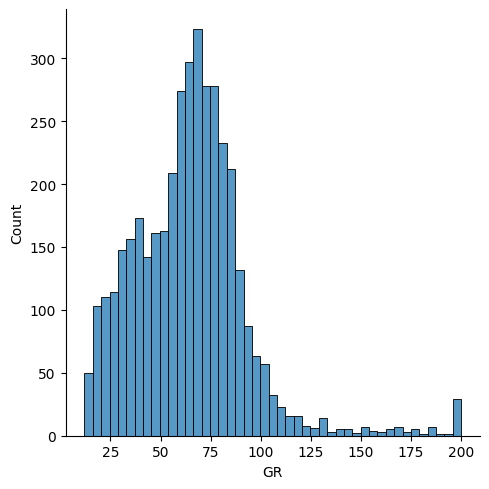

In [10]:
import seaborn as sns

sns.displot(df['GR'])

## Independence assumption

If a feature is correlated to lagged (shifted) versions of itself, then the dataset may be ordered by that feature, or the records may not be independent. If several features are correlated to themselves, then the data instances may not be independent.

In [11]:
rf.is_correlated(df['GR'])

True

This is order-dependent. That is, shuffling the data removes the correlation:

In [12]:
import numpy as np

gr = df['GR'].to_numpy(copy=True)
np.random.shuffle(gr)
rf.is_correlated(gr)

False

But this does not mean the records are independent &mdash; the only way around this issue is to split the data differently.

## Importance

We might like to see which of our features are more useful. There's a function for that:

In [13]:
features = ['GR', 'RHOB', 'PE', 'Noise']

rf.feature_importances(df[features], df['Lithology'])

array([0.42028113, 0.2001267 , 0.3180724 , 0.06151976])

As we'd hope, the `'Noise'` attribute is shown to be not very useful.

## Pipelines

To make things as easy as possible, it would be nice to have some smoke alarms in the pipeline. Redflag has some prebuilt smoke alarms, and you can also make your own.

Redflag's smoke alarms won't be able to catch everything, however. For example if the data are shuffled and/or randomly sampled in a split, it might be very hard to spot self-correlation. I'm not sure how to alert the user to that kind of error, other than by potentially providing a wrapped version of `train_test_split()`.

Anyway, let's split our data in a sensible way: by well.

In [14]:
features = ['GR', 'RHOB', 'PE', 'Noise']
test_wells = ['CRAWFORD', 'STUART']

test_flag = df['Well Name'].isin(test_wells)

X_test = df.loc[test_flag, features]
y_test = df.loc[test_flag, 'Lithology']
X_train = df.loc[~test_flag, features]
y_train = df.loc[~test_flag, 'Lithology']

In [15]:
rf.pipeline

Pipeline(steps=[('rf.imbalance', ImbalanceDetector()),
                ('rf.clip', ClipDetector()),
                ('rf.correlation', CorrelationDetector()),
                ('rf.outlier', OutlierDetector()),
                ('rf.distributions', DistributionComparator()),
                ('rf.importance', ImportanceDetector())])

We can include this in other pipelines:

In [16]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), rf.pipeline, SVC())
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('rf.imbalance', ImbalanceDetector()),
                                 ('rf.clip', ClipDetector()),
                                 ('rf.correlation', CorrelationDetector()),
                                 ('rf.outlier', OutlierDetector()),
                                 ('rf.distributions', DistributionComparator()),
                                 ('rf.importance', ImportanceDetector())])),
                ('svc', SVC())])

In [17]:
pipe.fit(X_train, y_train)

🚩 The labels are imbalanced by more than the threshold (0.420 > 0.400). See self.minority_classes_ for the minority classes.
🚩 Features 0, 1 have samples that may be clipped.
🚩 Features 0, 1, 2 have samples that may be correlated.
🚩 There are more outliers than expected in the training data (316 vs 31).
🚩 Feature 3 has low importance; check for relevance.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('rf.imbalance', ImbalanceDetector()),
                                 ('rf.clip', ClipDetector()),
                                 ('rf.correlation', CorrelationDetector()),
                                 ('rf.outlier',
                                  OutlierDetector(threshold=3.643721188696941)),
                                 ('rf.distributions', DistributionComparator()),
                                 ('rf.importance', ImportanceDetector())])),
                ('svc', SVC())])

In [18]:
pipe.predict(X_test)

🚩 Feature 0 has samples that may be clipped.
🚩 Features 0, 1, 2 have samples that may be correlated.
🚩 There are more outliers than expected in the data (26 vs 8).
🚩 Feature 2 has a distribution that is different from training.


array(['siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'sandstone', 'wackestone',
       'wackestone', 'wackestone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'limestone', 'limestone', 'limestone',
       'wackestone', 'wackestone', 'wackestone', 'wackestone',
       'siltstone', 'siltstone', 'siltstone', 'mudstone', 'mudstone',
       'mudstone', 'mudstone', 'mudstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'mudstone', 'wackestone', 'limestone',
   

## Making your own tests

In [20]:
from redflag import Detector

def has_negative(x) -> bool:
    """Returns True, i.e. triggers, if any samples are negative."""
    return any(x < 0)

negative_detector = Detector(has_negative, "are negative")

pipe = make_pipeline(negative_detector, SVC())  # NB, no standardization.
pipe.fit(X_train, y_train)

🚩 Feature 3 has samples that are negative.


Pipeline(steps=[('detector',
                 Detector(func=<function BaseRedflagDetector.__init__.<locals>.<lambda> at 0x7f5de3dbeca0>,
                          warning='are negative')),
                ('svc', SVC())])

The noise feature we added has negative values; the others are all positive, which is what we expect for these data.

(Careful! All standardized features will have negative values.)